# The first attempt to recreate a KAN

In [39]:
import torch.nn as nn
import torch
import numpy as np
from spline import *
from utils import *
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

In [40]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape, dataset['test_input'].shape, dataset['test_label'].shape

X_train, y_train, X_test, y_test = dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']

In [41]:
# creating a KAN layer from scratch
class MyKANLayer(nn.Module):

    def __init__(self, in_dim, out_dim, grid, degree=3, approx_type="taylor", grid_range=[-1, 1], device='cpu'):
        super(MyKANLayer, self).__init__()

        # initiliaze variables about the layer
        self.size = size = out_dim * in_dim
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.degree = degree
        self.grid_range = grid_range
        self.cache = None
        self.approx_type = approx_type

        # The spline function requires three parameters: knots, coeff, and degree
        # knots: the grid points for the spline
        # self.knots = nn.Parameter(torch.linspace(grid_range[0], grid_range[1], steps=grid + 1, device=device).repeat(size, 1)).requires_grad_(False)
        self.knots = nn.Parameter(torch.linspace(grid_range[0], grid_range[1], steps=grid + 1, device=device), requires_grad=False)

        # coeff: the coefficients for the spline - these are learnable!
        # I am wrapping them in a parameter since that is what they are
        # grid + 
        self.coeff = nn.Parameter(0.1 * torch.randn(size, 1 + degree, device=device), requires_grad=True)


    def forward(self, x):

        # we process data in batches!
        batch_size = x.shape[0]

        # we need to repeat the input for each spline function
        # x.shape = (size, batch_size)
        x = x.transpose(0, 1).repeat(self.out_dim, 1)

        # store the input for later
        self.cache = x

        # store the output of the spline functions
        out = torch.zeros(self.size, batch_size)


        # OLD WAY: WITH BUILT-IN B-SPLINE FUNCTION, WHICH DOES NOT PROVIDE US WITH GRADIENTS
        # for i in range(self.size):
        #     # x[i].shape = batch_size
        #     spline = BSpline(self.knots, self.coeff[i].detach().numpy(), self.degree)
        #     out[i] = torch.tensor(spline(x[i]))


        # loop through all the spline functions, and apply them to a single element for the whole batch
        # TODO: see if we can vectorize this
        for i in range(self.size):
            # Use torch operations to evaluate the B-spline
            knots = self.knots
            coeff = self.coeff[i]

            # spline_values = self.evaluate_spline(x[i], knots, coeff, self.degree)
            # out[i] = spline_values

            taylor_values = self.evaluate_taylor_series(x[i], coeff, self.degree)
            out[i] = taylor_values


        # reshape the output to be of shape (out_dim, in_dim, batch_size)
        # then we sum it as part of the algorithm
        # then we transpose it so subsequent layers can use it
        y = out.reshape(self.out_dim, self.in_dim, batch_size).sum(dim=1).transpose(0, 1)

        return y
    



    def evaluate_spline(self, x, knots, coeff, degree):
        # Implement the B-spline evaluation directly in PyTorch
        # This is a simplified version and assumes a cubic B-spline (degree=3)
        assert degree == 3, "This implementation only supports cubic B-splines (degree=3)"

        # Initialize the B-spline basis functions
        n_knots = len(knots)
        n_coeffs = len(coeff)
        # assert n_knots == n_coeffs + degree + 1, "Mismatch between number of knots and coefficients for cubic B-splines"

        # Implement basis function evaluation (recursively or using a loop)
        # This example uses a loop for simplicity
        B = torch.zeros(x.shape[0], n_coeffs)

        # Basis function calculation
        for i in range(n_coeffs):
            B[:, i] = self.basis_function(x, knots, i, degree)

        # Evaluate the spline
        spline_values = B.matmul(coeff)

        return spline_values


    def basis_function(self, x, knots, degree):
        # Compute the B-spline basis function value
        # This is a placeholder for the basis function calculation
        pass

        # You need to implement the Cox-de Boor recursion formula here
        


    def evaluate_taylor_series(self, x, coeff, degree):
        # Evaluate the Taylor series of x using the coefficients
        exp = torch.arange(degree+1).view(1, -1).repeat(x.shape[0], 1)
        powed = torch.pow(x.view(-1, 1), exp)
        
        return torch.sum(coeff * powed, dim=1)

        



    




    # If we want to plot the spline curves of a layer
    def plot(self):
        # Plot the spline functions (optional)
        points = torch.linspace(self.grid_range[0], self.grid_range[1], 100)

        if self.approx_type == "spline":
            for i in range(self.size):
                spline = BSpline(self.knots.cpu().numpy(), self.coeff[i].detach().cpu().numpy(), self.degree)
                y = spline(points)
                plt.plot(points, y, label=f'B_{i,3}(points)')
        else:
            for i in range(self.size):
                y = self.evaluate_taylor_series(points, coeff=self.coeff[i], degree=self.degree).detach().cpu().numpy()
                plt.plot(points, y, label=f'B_{i,3}(points)')
            
        plt.title('Cubic B-spline Basis Functions')
        plt.xlabel('x')
        plt.ylabel('B_{i,3}(points)')
        plt.legend()
        plt.show()


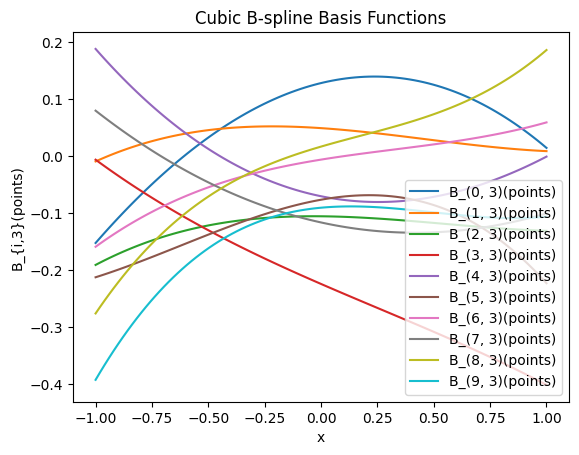

In [42]:
# Testing the layer
layer = MyKANLayer(in_dim=2, out_dim=5, grid=9, approx_type="taylor", degree=3)

out = layer(dataset['train_input'][:2])
out
layer.plot()

In [43]:
class MyKAN(nn.Module):
    
    def __init__(self, width=None, grid=3, degree=3, approx_type="taylor", seed=69, device='cpu'):
        super(MyKAN, self).__init__()

        # intialize variables for the KAN
        self.biases = []
        self.act_fun = nn.ModuleList()
        self.depth = len(width) - 1
        self.width = width

        # create the layers here
        for l in range(self.depth):
            kan_layer = MyKANLayer(width[l], width[l+1], grid, degree, approx_type, device=device)
            self.act_fun.append(kan_layer)

    # x should only be passed in batches
    def forward(self, x):

        # ensure the input is a vector
        # This means images are flattened
        x = x.view(x.size(0), -1)


        for l in range(self.depth):
            x = self.act_fun[l](x)
            
        return x
    
    def plot(self):
        for l in range(self.depth):
            self.act_fun[l].plot()

In [44]:
# test the KAN here
model = MyKAN(width=[2, 1, 1], grid=10, degree=4, approx_type="taylor", device='cpu')

out = model(dataset['train_input'][:10])
out

tensor([[-0.0480],
        [-0.0592],
        [-0.0529],
        [-0.0434],
        [-0.0432],
        [-0.0742],
        [-0.0683],
        [-0.0471],
        [-0.0757],
        [-0.0308]], grad_fn=<TransposeBackward0>)

# Testing on toy dataset

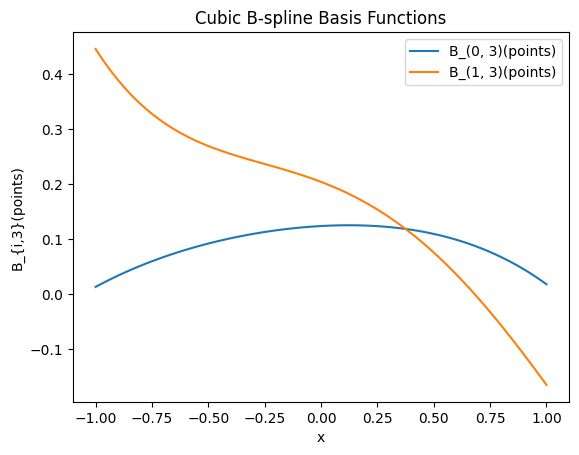

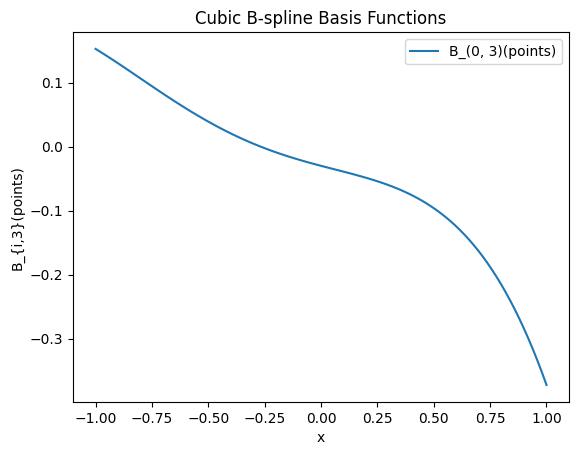

Epoch [1000/10000], Loss: 0.1419
Epoch [2000/10000], Loss: 0.0242
Epoch [3000/10000], Loss: 0.0156
Epoch [4000/10000], Loss: 0.0127
Epoch [5000/10000], Loss: 0.0111
Epoch [6000/10000], Loss: 0.0102
Epoch [7000/10000], Loss: 0.0098
Epoch [8000/10000], Loss: 0.0094
Epoch [9000/10000], Loss: 0.0090
Epoch [10000/10000], Loss: 0.0088


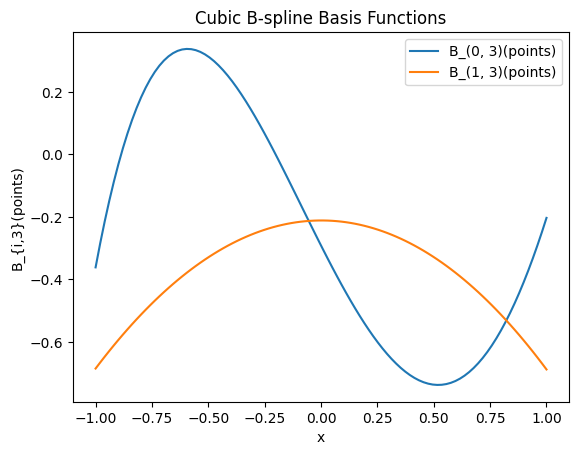

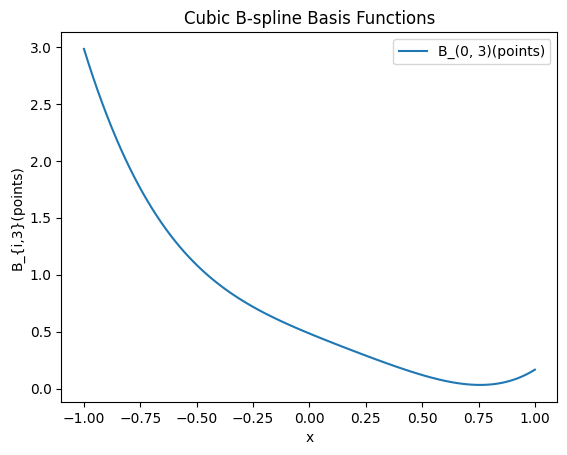

Test Loss: 0.0093


In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# MSE Loss
criterion = nn.MSELoss()



num_epochs = 10000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    optimizer.zero_grad()  # Zero the gradients

    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Compute the loss

    # does not solve issue, because of this error does not go down
    # loss = torch.autograd.Variable(loss, requires_grad = True)

    loss.backward()  # Backward pass (compute gradients)
    optimizer.step()  # Update the parameters

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    if (epoch+1) % 10000 == 0 or epoch == 0:
        model.plot()

# After training, you can evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test)  # Forward pass on the training data
    test_loss = criterion(test_outputs, y_test)  # Compute the loss
    print(f'Test Loss: {test_loss.item():.4f}')